In [ ]:
!pip install torch
!pip install torchvision
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import torch.nn.functional as F
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import time
from torch.optim.lr_scheduler import StepLR


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
  Using cached nvidia_nvjitlink_cu12-12.4.127-py3-none-m

In [ ]:
batch = 64
epochs = 20
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
valid_dataset = datasets.MNIST(root='./data', train=True, transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 38691528.63it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1167966.97it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 9500986.24it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 8627956.87it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
validation_fraction = 0.1
num = int(validation_fraction * 60000)
train_indices = torch.arange(0, 60000 - num)
valid_indices = torch.arange(60000 - num, 60000)
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(valid_indices)

In [ ]:
train_loader = DataLoader(dataset=trainset, batch_size=batch, drop_last=True, sampler=train_sampler)
valid_loader = DataLoader(dataset=valid_dataset, batch_size=batch, sampler=valid_sampler)
test_loader = DataLoader(dataset=testset, batch_size=batch, shuffle=False)

In [ ]:
for images, labels in train_loader:
  print(images[0].shape, labels[0])
  break

torch.Size([1, 28, 28]) tensor(8)


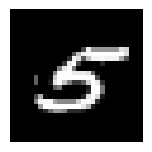

In [ ]:
# Display a grid of sample images
plt.figure(figsize=(10, 10))
for i, (images, labels) in enumerate(train_loader):
  for j in range(25):
    plt.subplot(5, 5, j + 1)
    plt.imshow(images[j].squeeze(), cmap='gray')
    plt.axis('off')
    break
plt.show()


In [ ]:
class MLP(nn.Module):
  def __init__(self, num_features, num_hidden_1, num_hidden_2, num_classes):
    super().__init__()
    self.network = torch.nn.Sequential(
    # 1st hidden layer
    torch.nn.Flatten(),
    torch.nn.Linear(num_features, num_hidden_1),
    torch.nn.BatchNorm1d(num_hidden_1),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
  # 2nd hidden layer
  torch.nn.Linear(num_hidden_1, num_hidden_2),
  torch.nn.BatchNorm1d(num_hidden_2),
  torch.nn.ReLU(),
  torch.nn.Dropout(0.3),
  # output layer
  torch.nn.Linear(num_hidden_2, num_classes)
)

  def forward(self, x):
    logits = self.network(x)
    return logits

In [ ]:
model = MLP(num_features=28*28,
num_hidden_1=128,
num_hidden_2=64,
num_classes=10)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9,
weight_decay=0.0001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,
factor=0.1,
mode='min')

In [ ]:
# Define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# Scheduler with step decay
scheduler = StepLR(optimizer, step_size=30, gamma=0.1)


In [ ]:
def compute_accuracy(data_loader):
  with torch.no_grad():
    correct_pred, num_examples = 0, 0
    for i, (features, targets) in enumerate(data_loader):
      features = features.to(device)
      targets = targets.float().to(device)
      logits = model(features)
      _, predicted_labels = torch.max(logits, 1)
      num_examples += targets.size(0)
      correct_pred += (predicted_labels == targets).sum()
  return correct_pred.float()/num_examples * 100

In [ ]:
start_time = time.time()
minibatch_loss_list, train_acc_list, valid_acc_list = [], [], []
for epoch in range(epochs):
  model.train()
  for batch_idx, (features, targets) in enumerate(train_loader):
    features = features.to(device)
    targets = targets.to(device)
    # ## FORWARD AND BACK PROP
    logits = model(features)
    #loss = F.cross_entropy(logits, targets)
    loss = criterion(logits, targets)
    optimizer.zero_grad()
    loss.backward()
    # ## UPDATE MODEL PARAMETERS
    optimizer.step()
    # ## LOGGING
    minibatch_loss_list.append(loss.item())
    logging_interval = 100
    if not batch_idx % logging_interval:
      print("Epoch: ", epoch+1,"/", epochs,"| Batch ",batch_idx,
    "/",len(train_loader), f'| Loss: {loss:.4f}')
  model.eval()
  with torch.no_grad(): # save memory during inference
    train_acc = compute_accuracy(train_loader)
    valid_acc = compute_accuracy(valid_loader)
    print("Epoch: ", epoch+1, "/",epochs, "completed",
    f'| Train: {train_acc :.2f}% '
    f'| Validation: {valid_acc :.2f}%')
    train_acc_list.append(train_acc.item())
    valid_acc_list.append(valid_acc.item())
elapsed = (time.time() - start_time)/60
print("Time elapsed: ",elapsed, " min")
scheduler.step(minibatch_loss_list[-1])
elapsed = (time.time() - start_time)/60
print(f'Total Training Time: {elapsed:.2f} min')
test_acc = compute_accuracy(test_loader)
print(f'Test accuracy {test_acc :.2f}%')

Epoch:  1 / 20 | Batch  0 / 843 | Loss: 2.3129
Epoch:  1 / 20 | Batch  100 / 843 | Loss: 0.6639
Epoch:  1 / 20 | Batch  200 / 843 | Loss: 0.6327
Epoch:  1 / 20 | Batch  300 / 843 | Loss: 0.4612
Epoch:  1 / 20 | Batch  400 / 843 | Loss: 0.4147
Epoch:  1 / 20 | Batch  500 / 843 | Loss: 0.1736
Epoch:  1 / 20 | Batch  600 / 843 | Loss: 0.3688
Epoch:  1 / 20 | Batch  700 / 843 | Loss: 0.1921
Epoch:  1 / 20 | Batch  800 / 843 | Loss: 0.3725
Epoch:  1 / 20 completed | Train: 94.58% | Validation: 95.87%
Epoch:  2 / 20 | Batch  0 / 843 | Loss: 0.2415
Epoch:  2 / 20 | Batch  100 / 843 | Loss: 0.5284
Epoch:  2 / 20 | Batch  200 / 843 | Loss: 0.3307
Epoch:  2 / 20 | Batch  300 / 843 | Loss: 0.3839
Epoch:  2 / 20 | Batch  400 / 843 | Loss: 0.2891
Epoch:  2 / 20 | Batch  500 / 843 | Loss: 0.3198
Epoch:  2 / 20 | Batch  600 / 843 | Loss: 0.4130
Epoch:  2 / 20 | Batch  700 / 843 | Loss: 0.2191
Epoch:  2 / 20 | Batch  800 / 843 | Loss: 0.2663
Epoch:  2 / 20 completed | Train: 96.09% | Validation: 96.63

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Test accuracy 97.78%


Text(0, 0.5, 'Loss')

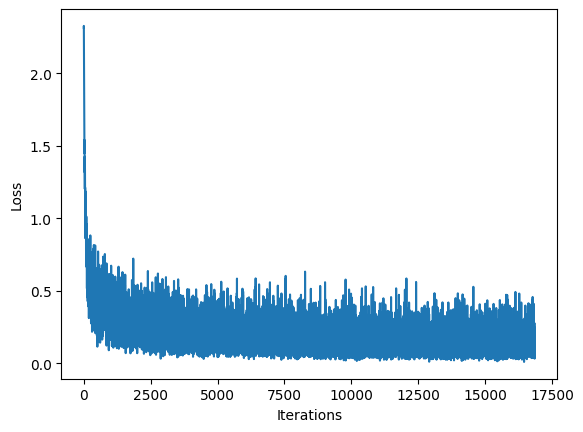

In [ ]:
plt.plot(range(len(minibatch_loss_list)), minibatch_loss_list)
plt.xlabel('Iterations')
plt.ylabel('Loss')

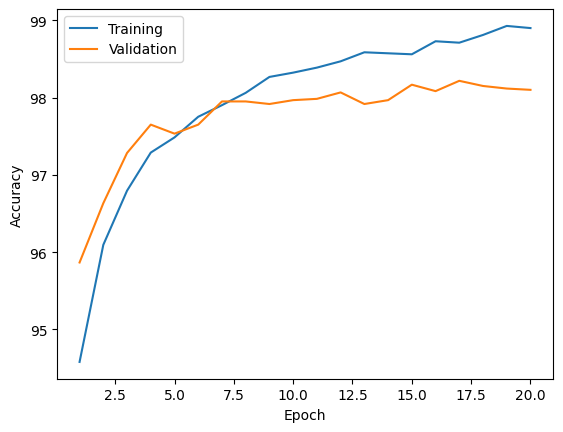

In [ ]:
num_epochs = len(train_acc_list)
plt.plot(np.arange(1, num_epochs+1),
train_acc_list, label='Training')
plt.plot(np.arange(1, num_epochs+1),
valid_acc_list, label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

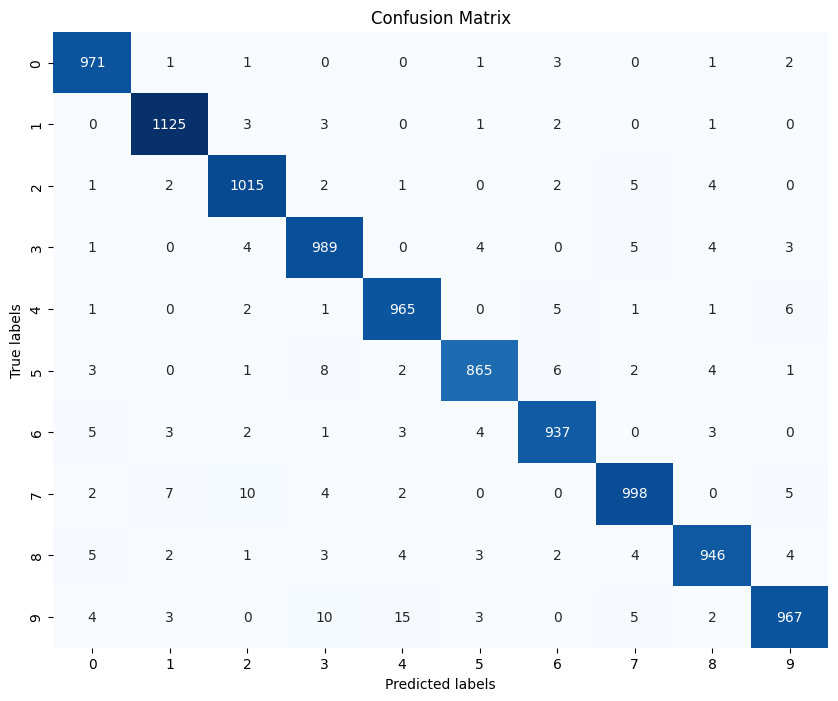

In [22]:
# Set the model to evaluation
model.eval()

all_predictions = []
all_targets = []

# Iterate over the test dataset
for features, targets in test_loader:
    # Move data to the device
    features = features.to(device)
    targets = targets.to(device)

    # Forward pass
    logits = model(features)

    # Get predictions
    _, predicted_labels = torch.max(logits, 1)

    # Append predictions and actual labels to the lists
    all_predictions.extend(predicted_labels.cpu().numpy())
    all_targets.extend(targets.cpu().numpy())

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_targets = np.array(all_targets)

# Generate confusion matrix
conf_matrix = confusion_matrix(all_targets, all_predictions)
classes = range(10)

# Display confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes, cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()


In [23]:
from sklearn.metrics import classification_report

# Classification report
report = classification_report(all_targets, all_predictions, target_names=[str(i) for i in range(10)])

# Print classification report
print(report)


              precision    recall  f1-score   support

           0       0.98      0.99      0.98       980
           1       0.98      0.99      0.99      1135
           2       0.98      0.98      0.98      1032
           3       0.97      0.98      0.97      1010
           4       0.97      0.98      0.98       982
           5       0.98      0.97      0.98       892
           6       0.98      0.98      0.98       958
           7       0.98      0.97      0.97      1028
           8       0.98      0.97      0.98       974
           9       0.98      0.96      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

